# Description
This is the main file of this project covering football tweets analysis for one selected match. It can be run after scraping the tweets and training the models.
This file includes:
1. creating wordclouds - a picture with most frequent terms in tweets
2. tweets preprocessing 
3. sentiment prediction - with use of many standard models such as: Logistic Regression, SVM and SVM with features selection, Bernoulli Naive Bayes, Multinomial Naive Bayes, XGBoost
4. sentiment prediction with fasttext model
5. counting number of tweets over match time

In [1]:
# Run this cell just once! (or restart Kernel before second time)

import os

os.chdir('..')


In [135]:
import pickle
import re
from heapq import nlargest, nsmallest

import fastText
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy.signal import find_peaks

from utils.fixed import *


% matplotlib inline

#set pictures parameters
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['axes.labelsize'] = 12

plt.rcParams['lines.linewidth'] = 2


In [3]:
def create_teams_dataframes(match_df, team1, team2):
    #create two dataframes separate for each team
    team1_df = match_df[match_df.team == team1].sort_values(by=['tweetCreated'])
    team2_df = match_df[match_df.team == team2].sort_values(by=['tweetCreated'])
    team1_df = team1_df.drop_duplicates(subset=['tweetID']).reset_index(drop=True)
    team2_df = team2_df.drop_duplicates(subset=['tweetID']).reset_index(drop=True)
    return team1_df, team2_df

def calculate_sentiment_df(team_df):
    #count sum of sentiment values (0 or 1) and also sum of tweets for each minute of the match
    index = pd.DatetimeIndex(team_df['tweetCreated'])
    time_period = team_df['tweetCreated'].apply(lambda x: datetime.datetime.strftime(x, '%H:%M')).tolist()
    sent_df = pd.DataFrame(index=index, data=time_period, columns=['time_period'])
    sent_df['sentiment'] = np.array(list(team_df['sentiment']))
    count_df = sent_df.groupby(by=['time_period'], as_index=False).count()
    sent_df = sent_df.groupby(by=['time_period'], as_index=False).sum()
    return sent_df, count_df

def select_peaks(signal, n=5):
    #select n peaks (the highest values) of positive and negative sentiment for whole match time
    peaks_positive, _ = find_peaks(signal, height=0)
    peaks_negative, _ = find_peaks(-signal, height=0)
    signal_array = np.array(list(signal))
    maximas = nlargest(n, zip(signal_array[peaks_positive], peaks_positive))
    minimas = nsmallest(n, zip(signal_array[peaks_negative], peaks_negative))
    peaks_temp = maximas + minimas
    peaks = []
    for i, j in peaks_temp:
        peaks.append((j, i))
    return peaks

def plot_sentiment(sentiment_df, peaks, annotation_size=15, distance=2, title='', filename='',
                   y_label='sum of tweets sentiment per minute'):
    #create sentiment plot over the time with the highest peaks labels and optional: save it to file
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(sentiment_df['sentiment'])
    for i in range(len(peaks)):
        max_ann = peaks[i]
        if (peaks[i][1] < 0):
            font_color = 'red'
            distance = -distance
        else:
            font_color = 'green'
        ax.annotate(str(peaks[i][0]), xy=max_ann, xytext=(peaks[i][0], peaks[i][1] + distance), size=annotation_size,
                    color=font_color)
    ax.set_title(title, size=25)
    ax.set_xlabel('minutes of match (with extra time after first ans second half)')
    ax.set_ylabel(y_label)
    if filename != '':
        fig_path = os.path.join(MATCH_RESULT_PATH, filename)
        fig.savefig(fig_path, dpi=300)
    plt.show()


def draw_worcloud(text, filename):
    #show wordcloud and ave it to file
    fig_path = os.path.join(MATCH_RESULT_PATH, filename)
    wordcloud = WordCloud(width=1600, height=800, background_color="white").generate(text)
    plt.figure(figsize=(20, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.savefig(fig_path)
    plt.show()


## SHOW MATCHES AVAILABLE IN  MATCH_DATA

In [4]:
MATCH_DATA

,match,file_name,team1,team2,match_start,first_part_end,second_part_start,match_end,hashtags_team1,hashtags_team2
0,PSG-LIV,PSG_LIV.csv,PSG,Liverpool,2018-09-18 19:00,2018-09-18 19:46,2018-09-18 20:01,2018-09-18 20:55,"['#psg', '#parissaintgermain']","['#liverpoolfc', '#liverpool', '#lfc']"
1,MAN-NEW,MAN_NEW.csv,Manchester,Newcastle,2018-10-06 16:30,2018-10-06 17:17,2018-10-06 17:32,2018-10-06 18:17,"['#mufc', '#manutd', '#manchesterunited', '#re...","['#newcastle', '#newcastleunited', '#nufc']"
2,LIV-MAN,LIV_MAN.csv,Liverpool,Manchester City,2018-10-07 15:30,2018-10-07 16:17,2018-10-07 16:32,2018-10-07 17:20,"[#liverpoolfc,#liverpool,#lfc]","[#manchestercity,#mancity,#manchestercityfootb..."
3,VAL-BAR,VAL_BAR.csv,Valencia,Barcelona,2018-10-07 18:45,2018-10-07 19:32,2018-10-07 19:47,2018-10-07 20:35,"[#valenciacf, #yocreoenesteequipo, #valencia, ...","[#fcbarcelona, #barca, #igersbarca, #forcabarc..."
4,LEI-EVE,LEI_EVE.csv,Leicester,Everton,2018-10-06 14:00,2018-10-06 14:48,2018-10-06 15:03,2018-10-06 15:53,"[#leicester, #leicestercity, #lcfc, #foxes, #b...","[#everton, #efc, #coyb, #evertonfc]"
5,FUL-ARS,FUL_ARS.csv,Fulham,Arsenal,2018-10-07 11:00,2018-10-07 11:47,2018-10-07 12:02,2018-10-07 12:51,"[#fulham, #ffc, #coyw]","[#arsenal, #afc, #coyg, #gunners, #arsenalfc]"
6,SOU-CHE,SOU_CHE.csv,Southampton,Chelsea,2018-10-07 13:15,2018-10-07 14:02,2018-10-07 14:17,2018-10-07 15:06,"[#saintsfc, #southamptonfc, #wemarchon]","[#chelseafc, #chelsea, #cfc, #cfcfamily, #cfcf..."


### SELECT MATCH (match_id) WHICH YOU WANT TO ANALYSE

In [239]:
MATCH = "SOU-CHE"


### LOAD MATCH DATA AND TWEETS

In [240]:
SLANG_DICT = load_slang(SLANG_PATH)  #this dict is used to translate slang words into correct forms
file_path, team1, team2, match_start, first_part_end, \
second_part_start, match_end, hashtags_team1, hashtags_team2 = load_match_data(MATCH)
tweets_df = create_match_df(MATCH)


In [241]:
tweets_df

,tweetID,tweetText,tweetCreated,hashtag,team
0,1048952581379293186,Hughes out. #SaintsFC,2018-10-07 15:05:58,#saintsfc,Southampton
1,1048952579349258240,Morata gets a third. #SaintsFC,2018-10-07 15:05:58,#saintsfc,Southampton
2,1048952570046234627,Yep. Weird #saintsfc,2018-10-07 15:05:55,#saintsfc,Southampton
3,1048952567731032064,I’m in a pub watching #saintsfc with John of t...,2018-10-07 15:05:55,#saintsfc,Southampton
4,1048952567731032064,I’m in a pub watching #saintsfc with John of t...,2018-10-07 15:05:55,#saintsfc,Southampton
5,1048952564660756483,Bertrand\r\nLemina\r\nCedric\r\nRomeu\r\nHøjbj...,2018-10-07 15:05:54,#saintsfc,Southampton
6,1048952559719931904,#GOAL #Saintsfc 0-3 #CFC delicious football fr...,2018-10-07 15:05:53,#saintsfc,Southampton
7,1048952558717476864,@NathanRedmond22 @IngsDanny @LeminaM_13 @Mgabb...,2018-10-07 15:05:53,#saintsfc,Southampton
8,1048952557941473282,Great game #saintsfc,2018-10-07 15:05:53,#saintsfc,Southampton
9,1048952541134958592,Disappointing season so far for #SaintsFC 🤦🏾‍♂️😢,2018-10-07 15:05:49,#saintsfc,Southampton


### CREATE DIRECTORY FOR ANALYSIS RESULTS
All plots and pictures will be saved in the directory named after MATCH variable (for example: MAN-NEW) - separate folders for each match

In [242]:
MATCH_RESULT_PATH = os.path.join(MAIN_PATH, RESULTS_PATH, MATCH)
if not os.path.exists(MATCH_RESULT_PATH):
    os.makedirs(MATCH_RESULT_PATH)


# DRAW WORDCLOUD

### TWEETS PREPROCESSING FOR WORDCLOUD (removing stopwords and short words)

In [243]:
remove_stopwords = True
remove_shortwords = True
X_not_stemmed = get_processed_tweets(tweets_df, SLANG_DICT, remove_stopwords, remove_shortwords, stemmed=False,
                                     labels=False)
X_stemmed = get_processed_tweets(tweets_df, SLANG_DICT, remove_stopwords, remove_shortwords, stemmed=True, labels=False)


###  WORDCLOUD WITHOUT STEMMING

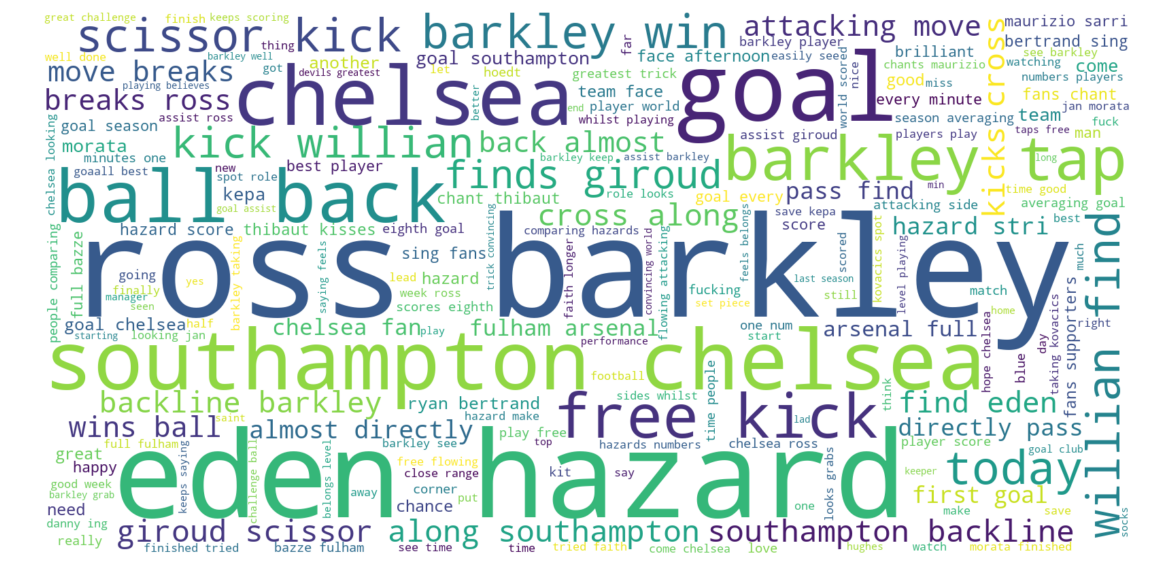

In [244]:
corpus = tweets_to_text(X_not_stemmed)
draw_worcloud(corpus, MATCH + '_wordcloud-not-stemmed.png')


### WORDCLOUD AFTER STEMMING

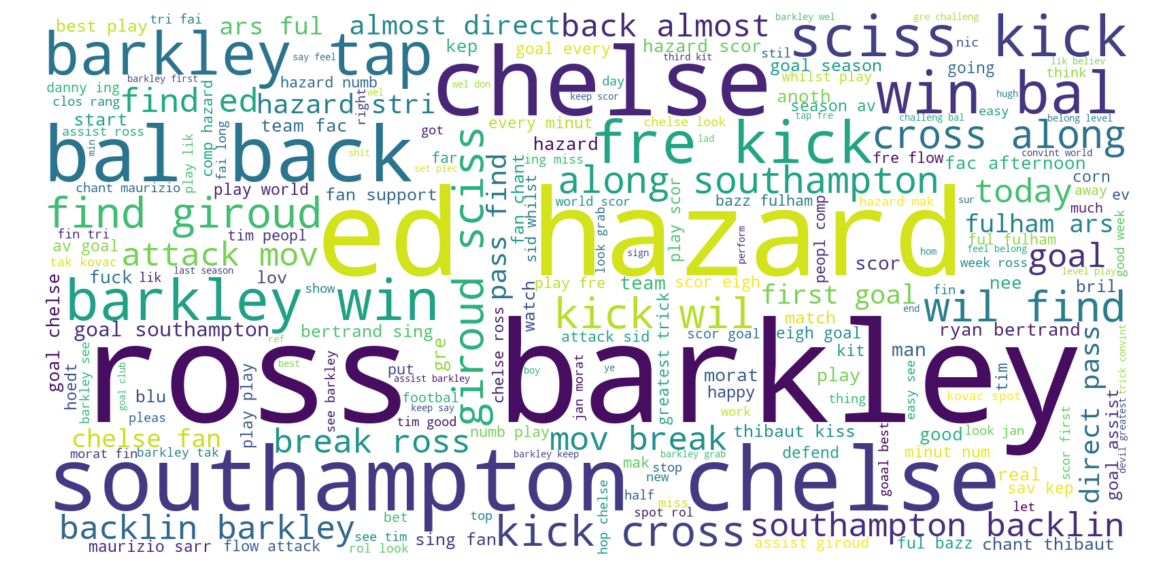

In [245]:
corpus_stemmed = tweets_to_text(X_stemmed)
draw_worcloud(corpus_stemmed, MATCH + '_wordcloud-stemmed.png')


# SENTIMENT PREDICTION

### PREPARE DATA
This is very imortant step. It uses get_processed_tweets() function from utils\fixed.py which removes all 'amp', 'rt', 'via', 'fav',"'s" words which are characteristic for tweets and redundant for this analysis. It also removes user mentions - @user, hashtags, links, punctuation and some very frequent words and expressions present in big amount of scrapped football tweets: 'v', 'vs', 'league', 'pl', 'link', 'live', 'stream', 'hd', 'premier league', 'champions league', 'matchday', 'epl', 'game', 'iphone', 'android', 'pc', 'mobile','ipad'. Preprocessing also includes translation of contractions and slang words, as well as replacing more than one withspace with one space.
After classifiers comparison in train_classic_classifiers.ipynb, it was decided not to remove stopwords and short words.
The function get_processed_tweets() has also "labels" argument which define whether the tweets_df dataframe which is passed as argument into the funtion has target column (y). Depending on it, the function returns X or X, y which are lists of clean tweets.

In [246]:
X = get_processed_tweets(tweets_df, SLANG_DICT, remove_stopwords=False, remove_shortwords=False, stemmed=True,
                         labels=False)
indexes = list(tweets_df.index)


 ## LOGISTIC REGRESSION

In [247]:
#load model
clf_name = 'logreg'
clf_path = os.path.join(MAIN_PATH, MODEL_PATH, 'logistic-regression.pkl')
with open(clf_path, 'rb') as f:
    vectorizer, clf = pickle.load(f)

#create vectors and predict sentiment
vectors = vectorizer.transform(X)
y = clf.predict(vectors)

#write sentiment to dataframe
tweets_df['sentiment'] = y

#create separate dataframes for teams
team1_df, team2_df = create_teams_dataframes(tweets_df, team1, team2)


### PLOT FIRST TEAM SENTIMENT


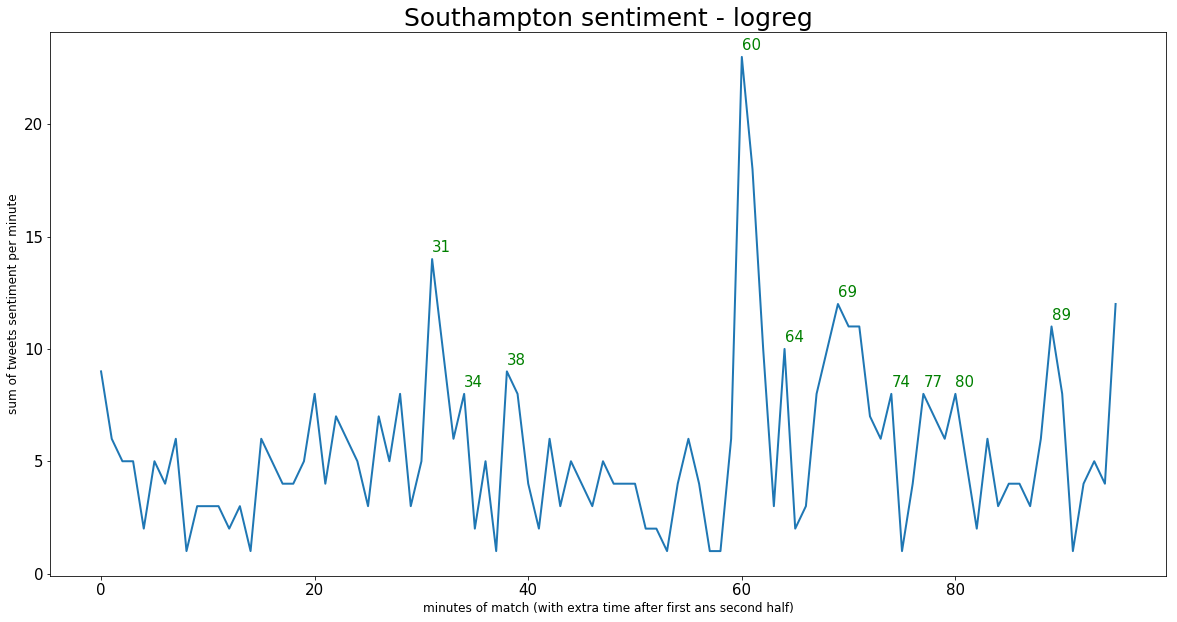

In [249]:
team1_sent, team1_count = calculate_sentiment_df(team1_df)
sent_peaks_team1 = select_peaks(team1_sent['sentiment'], n=10)
count_peaks_team1 = select_peaks(team1_count['sentiment'], n=10)

plot_sentiment(team1_sent, sent_peaks_team1, distance=0.3, title=team1 + " sentiment - " + clf_name,
               filename=team1 + '-sent-' + clf_name + '.jpg')


### PLOT SECOND TEAM SENTIMENT

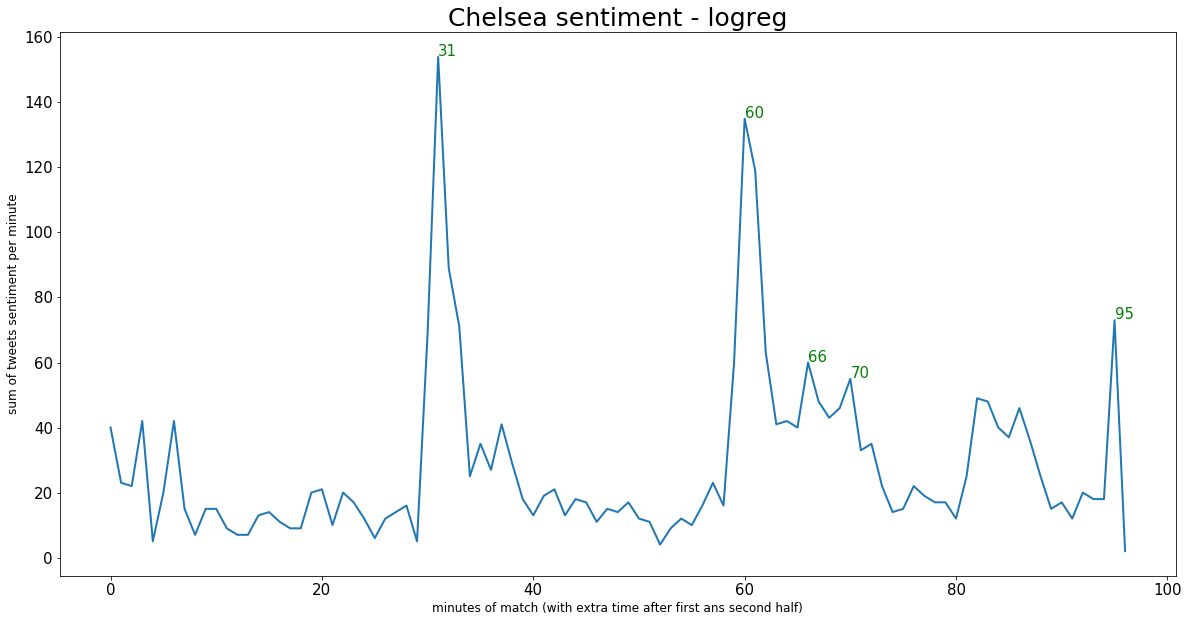

In [248]:
team2_sent, team2_count = calculate_sentiment_df(team2_df)
sent_peaks_team2 = select_peaks(team2_sent['sentiment'])
count_peaks_team2 = select_peaks(team2_count['sentiment'])
plot_sentiment(team2_sent, sent_peaks_team2, distance=0.3, title=team2 + " sentiment - " + clf_name,
               filename=team2 + '-sent-' + clf_name + '.jpg')


## LINEAR SVC

In [250]:
clf_name = 'svc'
clf_path = os.path.join(MAIN_PATH, MODEL_PATH, 'linearSVC.pkl')
with open(clf_path, 'rb') as f:
    vectorizer, clf = pickle.load(f)

vectors = vectorizer.transform(X)
y = clf.predict(vectors)
tweets_df['sentiment'] = y
team1_df, team2_df = create_teams_dataframes(tweets_df, team1, team2)


### PLOT FIRST TEAM SENTIMENT

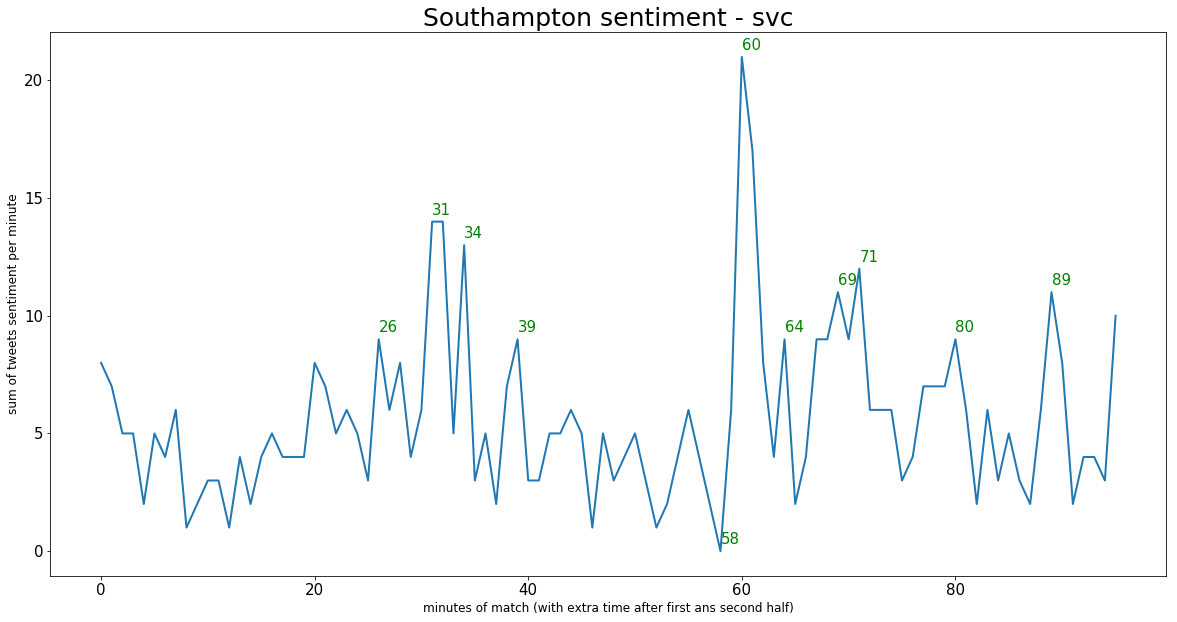

In [251]:
team1_sent, team1_count = calculate_sentiment_df(team1_df)
sent_peaks_team1 = select_peaks(team1_sent['sentiment'], n=10)
count_peaks_team1 = select_peaks(team1_count['sentiment'], n=10)
plot_sentiment(team1_sent, sent_peaks_team1, distance=0.3, title=team1 + " sentiment - " + clf_name,
               filename=team1 + '-sent-' + clf_name + '.jpg')
plt.show()


### PLOT SECOND TEAM SENTIMENT

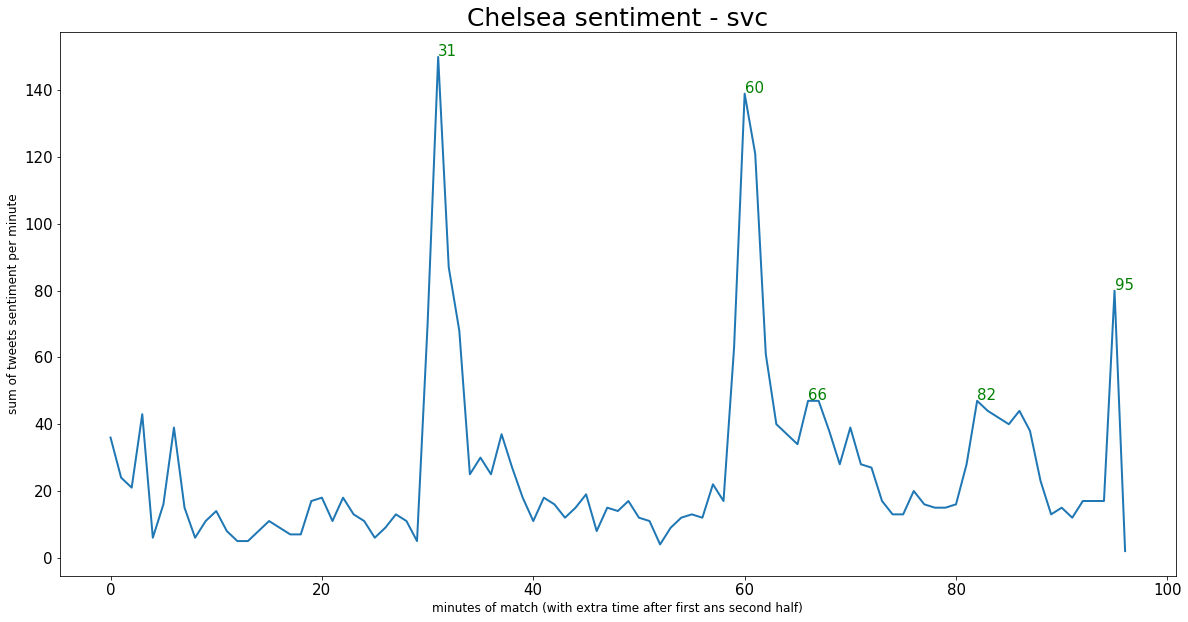

In [252]:
team2_sent, team2_count = calculate_sentiment_df(team2_df)
sent_peaks_team2 = select_peaks(team2_sent['sentiment'])
count_peaks_team2 = select_peaks(team2_count['sentiment'])
plot_sentiment(team2_sent, sent_peaks_team2, distance=0.3, title=team2 + " sentiment - " + clf_name,
               filename=team2 + '-sent-' + clf_name + '.jpg')
plt.show()


## BERNOULLI NB

In [253]:
clf_name = 'bnb'
clf_path = os.path.join(MAIN_PATH, MODEL_PATH, 'BernoulliNB.pkl')
with open(clf_path, 'rb') as f:
    vectorizer, clf = pickle.load(f)

vectors = vectorizer.transform(X)
y = clf.predict(vectors)
tweets_df['sentiment'] = y
team1_df, team2_df = create_teams_dataframes(tweets_df, team1, team2)


### PLOT FIRST TEAM SENTIMENT

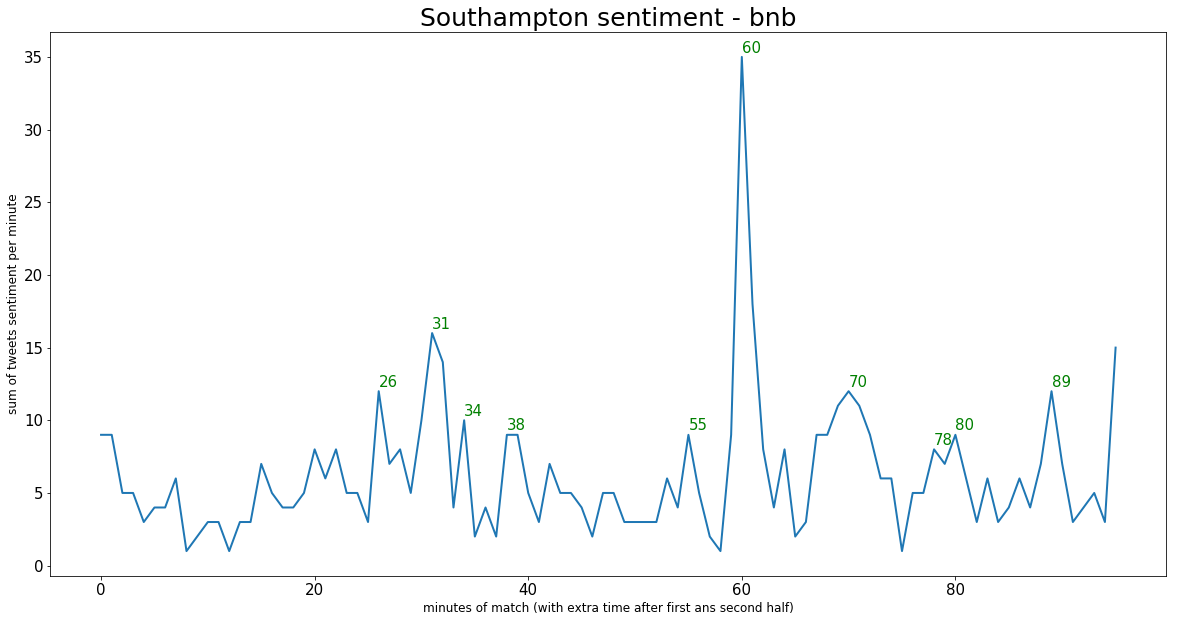

In [254]:
team1_sent, team1_count = calculate_sentiment_df(team1_df)
sent_peaks_team1 = select_peaks(team1_sent['sentiment'], n=10)
count_peaks_team1 = select_peaks(team1_count['sentiment'], n=10)
plot_sentiment(team1_sent, sent_peaks_team1, distance=0.3, title=team1 + " sentiment - " + clf_name,
               filename=team1 + '-sent-' + clf_name + '.jpg')
plt.show()


### PLOT SECOND TEAM SENTIMENT

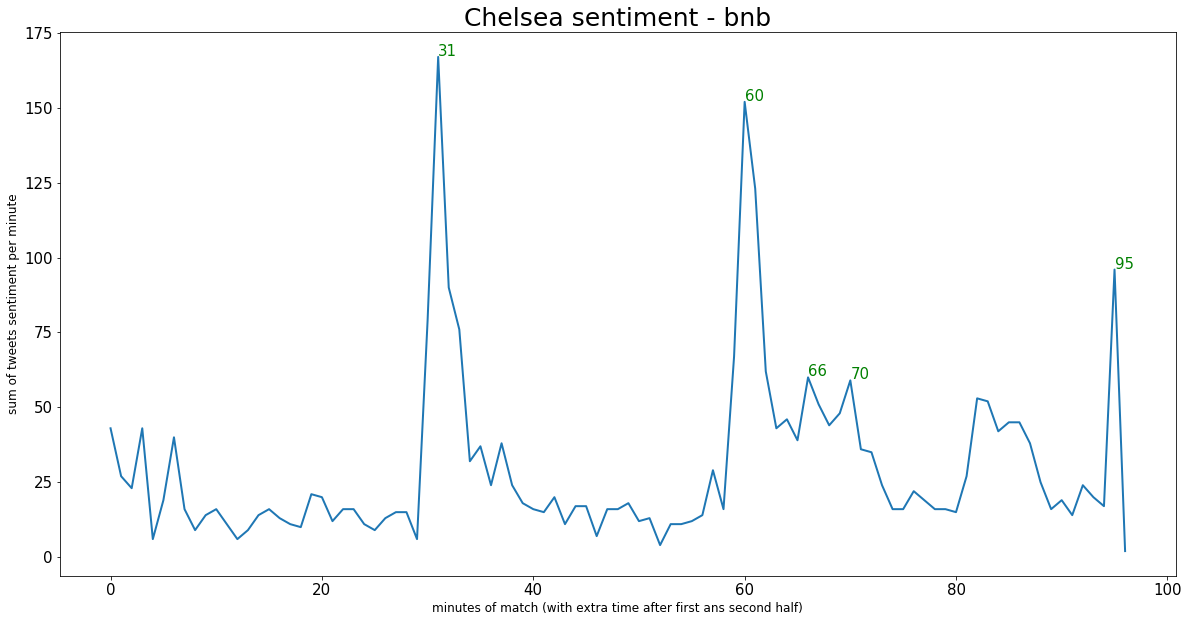

In [255]:
team2_sent, team2_count = calculate_sentiment_df(team2_df)
sent_peaks_team2 = select_peaks(team2_sent['sentiment'])
count_peaks_team2 = select_peaks(team2_count['sentiment'])
plot_sentiment(team2_sent, sent_peaks_team2, distance=0.3, title=team2 + " sentiment - " + clf_name,
               filename=team2 + '-sent-' + clf_name + '.jpg')
plt.show()


## MULTINOMIAL NB

In [256]:
clf_name = 'mnb'
clf_path = os.path.join(MAIN_PATH, MODEL_PATH, 'multinomialNB.pkl')
with open(clf_path, 'rb') as f:
    vectorizer, clf = pickle.load(f)

vectors = vectorizer.transform(X)
y = clf.predict(vectors)
tweets_df['sentiment'] = y
team1_df, team2_df = create_teams_dataframes(tweets_df, team1, team2)


### PLOT FIRST TEAM SENTIMENT

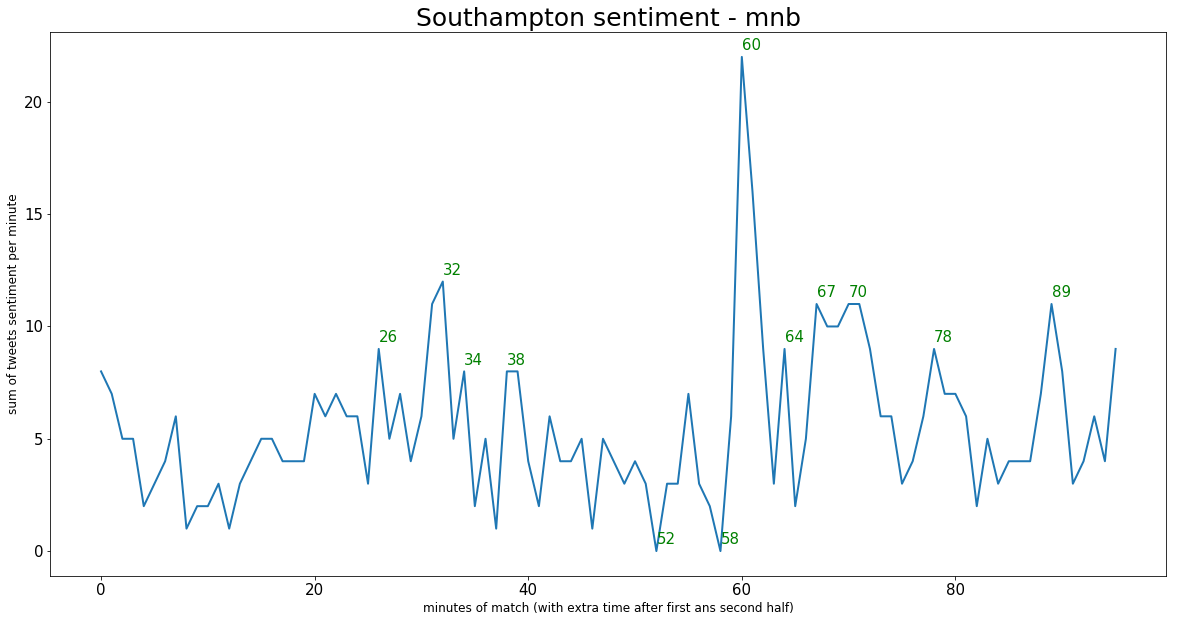

In [257]:
team1_sent, team1_count = calculate_sentiment_df(team1_df)
sent_peaks_team1 = select_peaks(team1_sent['sentiment'], n=10)
count_peaks_team1 = select_peaks(team1_count['sentiment'], n=10)
plot_sentiment(team1_sent, sent_peaks_team1, distance=0.3, title=team1 + " sentiment - " + clf_name,
               filename=team1 + '-sent-' + clf_name + '.jpg')
plt.show()


### PLOT SECOND TEAM SENTIMENT

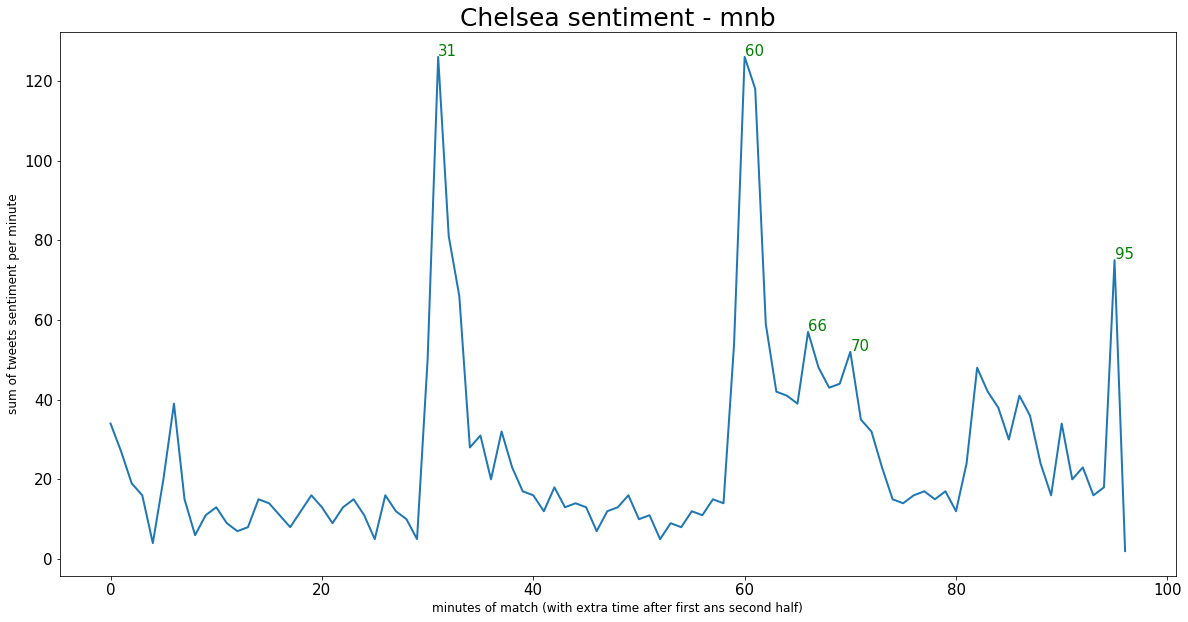

In [258]:
team2_sent, team2_count = calculate_sentiment_df(team2_df)
sent_peaks_team2 = select_peaks(team2_sent['sentiment'])
count_peaks_team2 = select_peaks(team2_count['sentiment'])
plot_sentiment(team2_sent, sent_peaks_team2, distance=0.3, title=team2 + " sentiment - " + clf_name,
               filename=team2 + '-sent-' + clf_name + '.jpg')
plt.show()


## XGBOOST

In [259]:
clf_name = 'xgb'
clf_path = os.path.join(MAIN_PATH, MODEL_PATH, 'XGBClassifier.pkl')
with open(clf_path, 'rb') as f:
    vectorizer, clf = pickle.load(f)

vectors = vectorizer.transform(X)
y = clf.predict(vectors)
tweets_df['sentiment'] = y
team1_df, team2_df = create_teams_dataframes(tweets_df, team1, team2)


### PLOT FIRST TEAM SENTIMENT

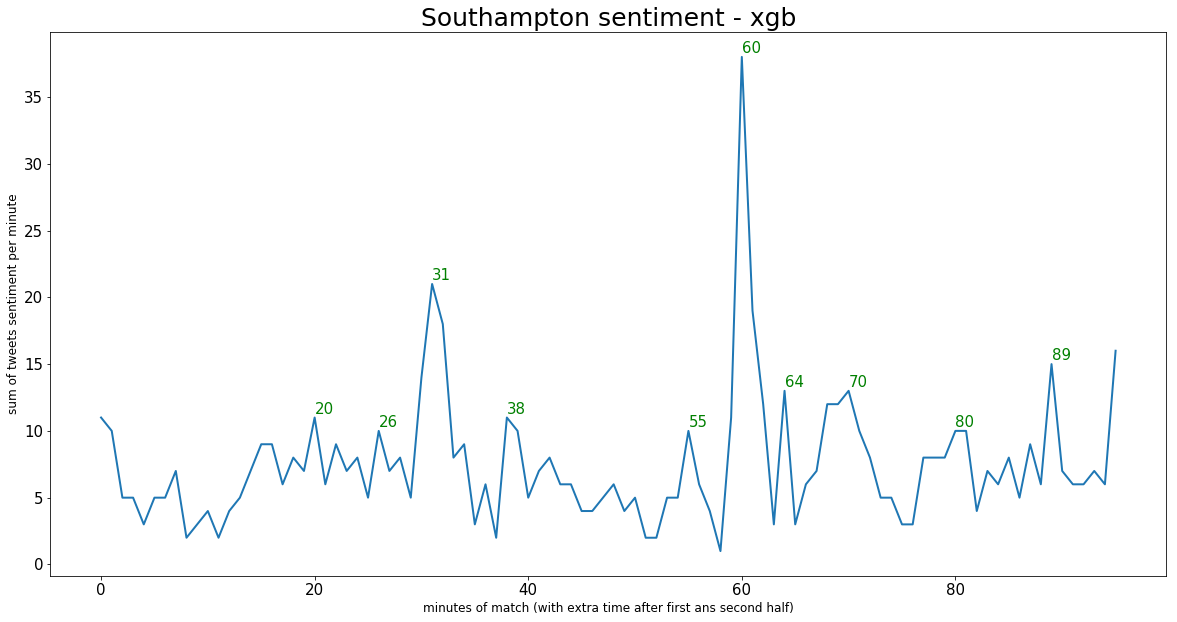

In [260]:
team1_sent, team1_count = calculate_sentiment_df(team1_df)
sent_peaks_team1 = select_peaks(team1_sent['sentiment'], n=10)
count_peaks_team1 = select_peaks(team1_count['sentiment'], n=10)
plot_sentiment(team1_sent, sent_peaks_team1, distance=0.3, title=team1 + " sentiment - " + clf_name,
               filename=team1 + '-sent-' + clf_name + '.jpg')
plt.show()


### PLOT SECOND TEAM SENTIMENT

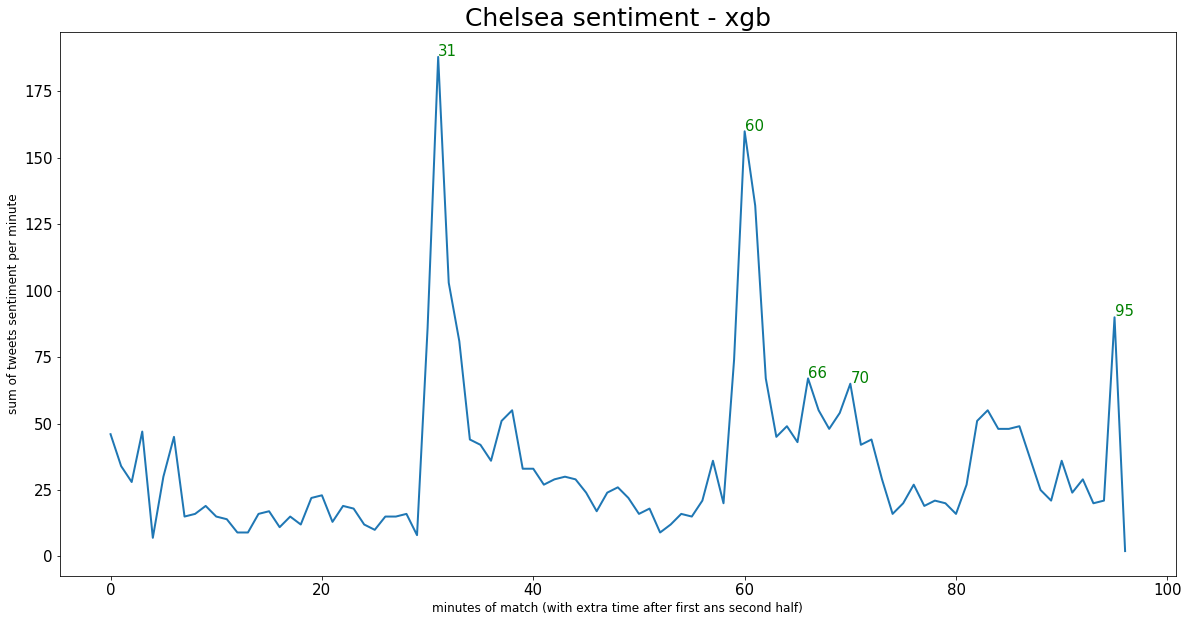

In [261]:
team2_sent, team2_count = calculate_sentiment_df(team2_df)
sent_peaks_team2 = select_peaks(team2_sent['sentiment'])
count_peaks_team2 = select_peaks(team2_count['sentiment'])
plot_sentiment(team2_sent, sent_peaks_team2, distance=0.3, title=team2 + " sentiment - " + clf_name,
               filename=team2 + '-sent-' + clf_name + '.jpg')
plt.show()


### SVC WITH FEATURES SELECTION

In [262]:
clf_name = 'svc-selection'
clf_path = os.path.join(MAIN_PATH, MODEL_PATH, 'SVC-with-selection.pkl')
with open(clf_path, 'rb') as f:
    vectorizer, clf = pickle.load(f)

vectors = vectorizer.transform(X)
y = clf.predict(vectors)
tweets_df['sentiment'] = y
team1_df, team2_df = create_teams_dataframes(tweets_df, team1, team2)


### PLOT FIRST TEAM SENTIMENT

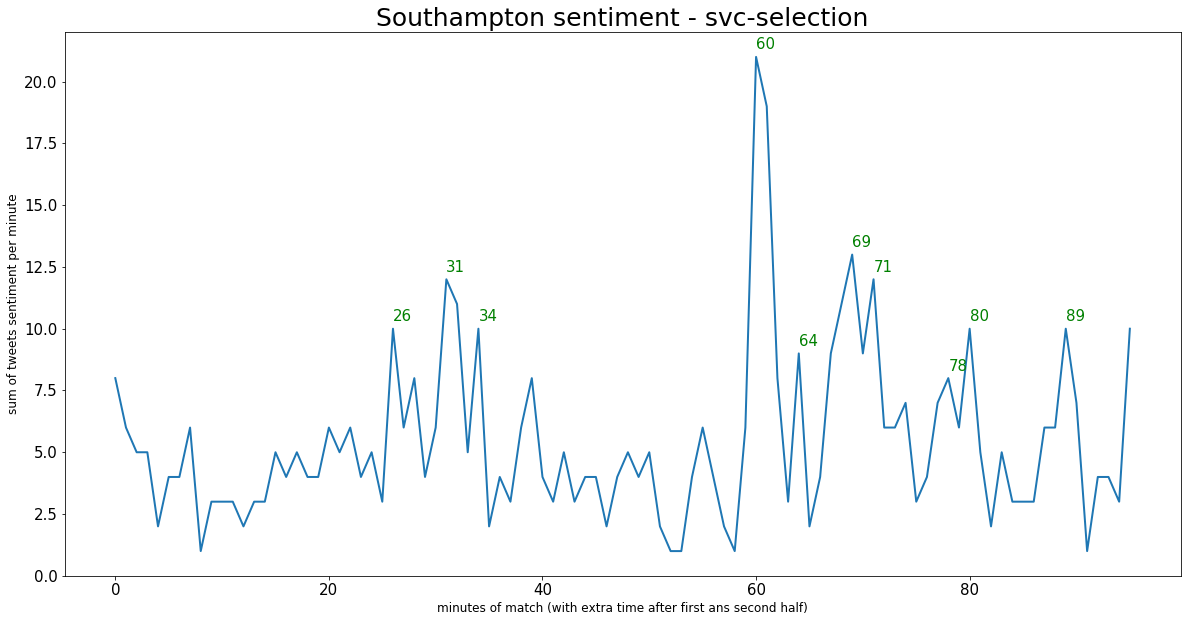

In [263]:
team1_sent, team1_count = calculate_sentiment_df(team1_df)
sent_peaks_team1 = select_peaks(team1_sent['sentiment'], n=10)
count_peaks_team1 = select_peaks(team1_count['sentiment'], n=10)
plot_sentiment(team1_sent, sent_peaks_team1, distance=0.3, title=team1 + " sentiment - " + clf_name,
               filename=team1 + '-sent-' + clf_name + '.jpg')
plt.show()


### PLOT SECOND TEAM SENTIMENT

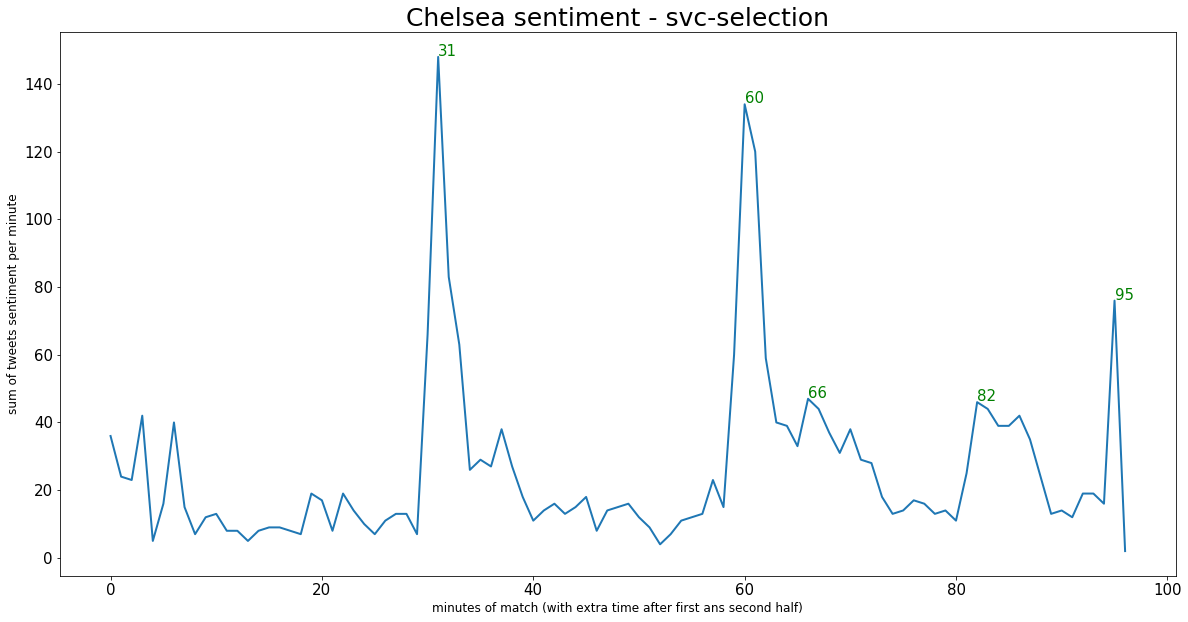

In [264]:
team2_sent, team2_count = calculate_sentiment_df(team2_df)
sent_peaks_team2 = select_peaks(team2_sent['sentiment'])
count_peaks_team2 = select_peaks(team2_count['sentiment'])
plot_sentiment(team2_sent, sent_peaks_team2, distance=0.3, title=team2 + " sentiment - " + clf_name,
               filename=team2 + '-sent-' + clf_name + '.jpg')
plt.show()


# FASTTEXT PREDICTION
In this section fasttext model is used which is created in train_fasttext_model.ipynb.

In [265]:
clf_name = 'fasttext'
model_filename = 'fasttext.model'
fasttext_model_path = os.path.join(MAIN_PATH, MODEL_PATH, model_filename)
model = fastText.load_model(fasttext_model_path)


### PREDICTION

In [266]:
labels = model.predict(X)


### PREPARE SENTIMENT LABELS
The result of fasttext prediciton is typle of list and numpy array. List contains another list with string - label. It can be \_\_label__1 for positive sentiment or \_\_label__0 for negative sentiment. They have to be changed to numeric format - integers becouse it is needed for calculating sum of sentiments per minute.

In [267]:
sentiment = [int(labels[0][i][0].replace('__label__', '').replace('0', '-1')) for i in range(len(labels[0]))]
tweets_df['sentiment'] = sentiment


### SPLIT DATA INTO TEAMS DATAFRAMES

In [268]:
team1_df, team2_df = create_teams_dataframes(tweets_df, team1, team2)


### PLOT FIRST TEAM SENTIMENT
The plot contains labels for 10 positive (green) and ten negative peaks (read) if exist.

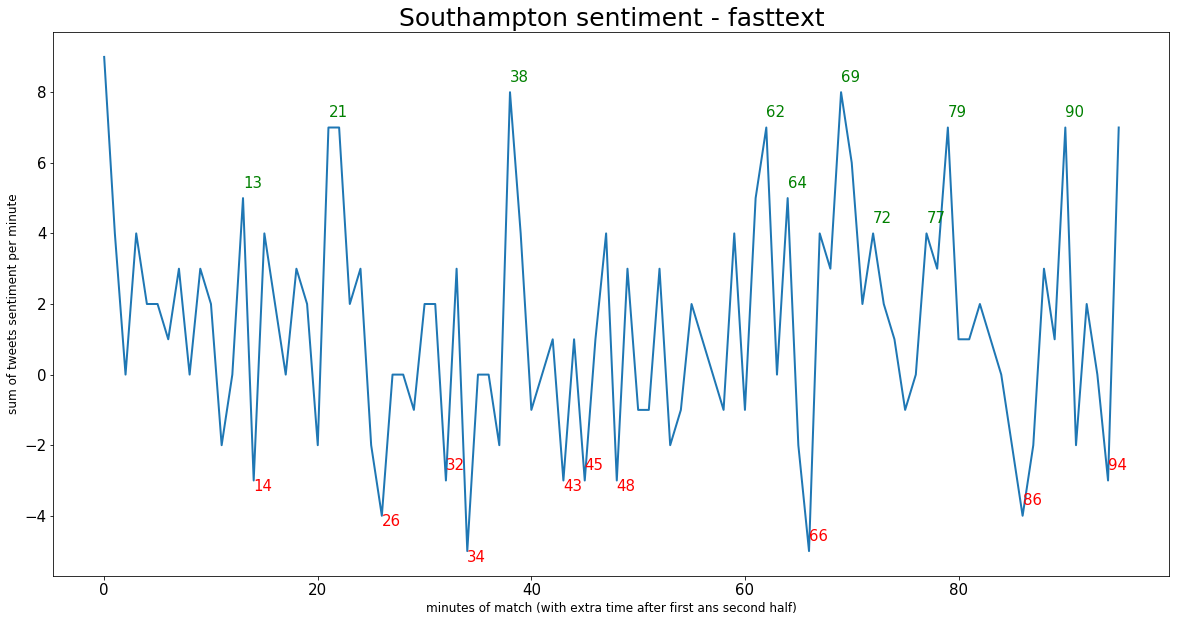

In [269]:
team1_sent, team1_count = calculate_sentiment_df(team1_df)
sent_peaks_team1 = select_peaks(team1_sent['sentiment'], n=10)
count_peaks_team1 = select_peaks(team1_count['sentiment'], n=10)
plot_sentiment(team1_sent, sent_peaks_team1, distance=0.3, title=team1 + " sentiment - " + clf_name,
               filename=team1 + '-sent-' + clf_name + '.jpg')
plt.show()


### PLOT SECOND TEAM SENTIMENT

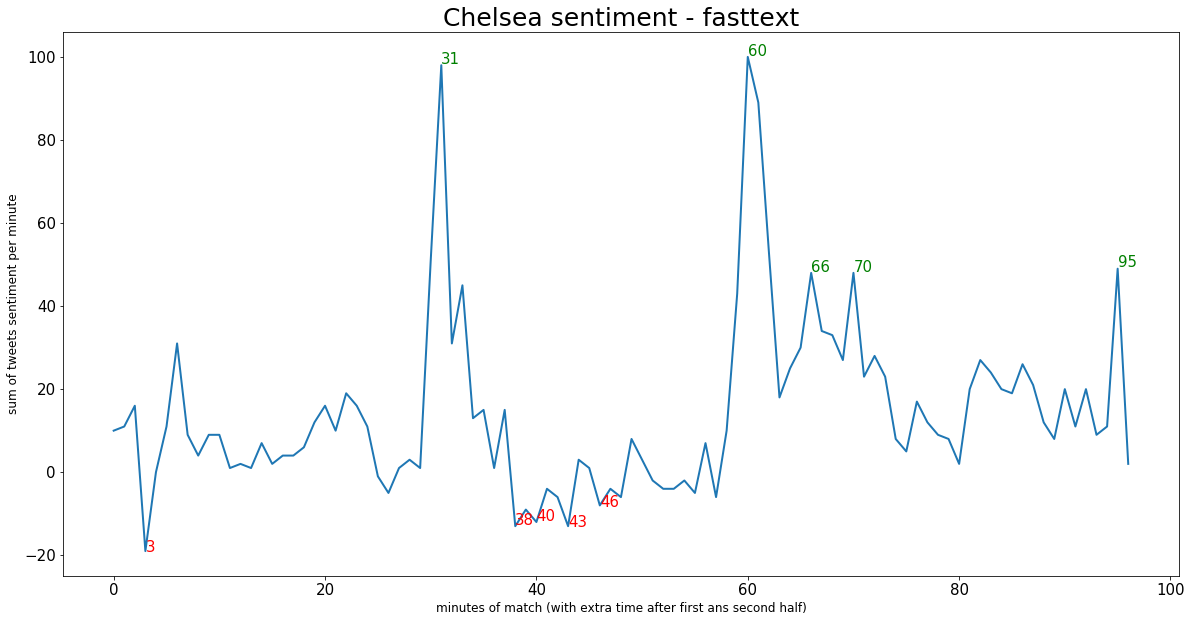

In [270]:
team2_sent, team2_count = calculate_sentiment_df(team2_df)
sent_peaks_team2 = select_peaks(team2_sent['sentiment'])
count_peaks_team2 = select_peaks(team2_count['sentiment'])
plot_sentiment(team2_sent, sent_peaks_team2, distance=0.3, title=team2 + " sentiment - " + clf_name,
               filename=team2 + '-sent-' + clf_name + '.jpg')


## CHECK MATCH DETAILS
Check if the peaks on sentiment plots are related to goals and other match important actions. The data returned in the dataframe present minutes of goals, cards receiving and other important actions. The minutes include extra time in first and second half.

In [271]:
match_detail_df = pd.read_csv(MATCH_DETAILS_PATH, sep=';', encoding='utf-8', index_col=0)
match_detail_df[match_detail_df['match'] == MATCH]


,match,goals_team1,goals_team2,action_team1,action_team2,cards_team1,cards_team2
6,SOU-CHE,NaN,"30, 59, 95","26, 82",8,"47, 56, 61, 64, 68, 92",NaN


# TWEETS COUNT OVER THE TIME
This section returns two plots (one for each team) with the number of tweets per minute. They contains labels for 10 peaks. The plots are saved as jpg files.

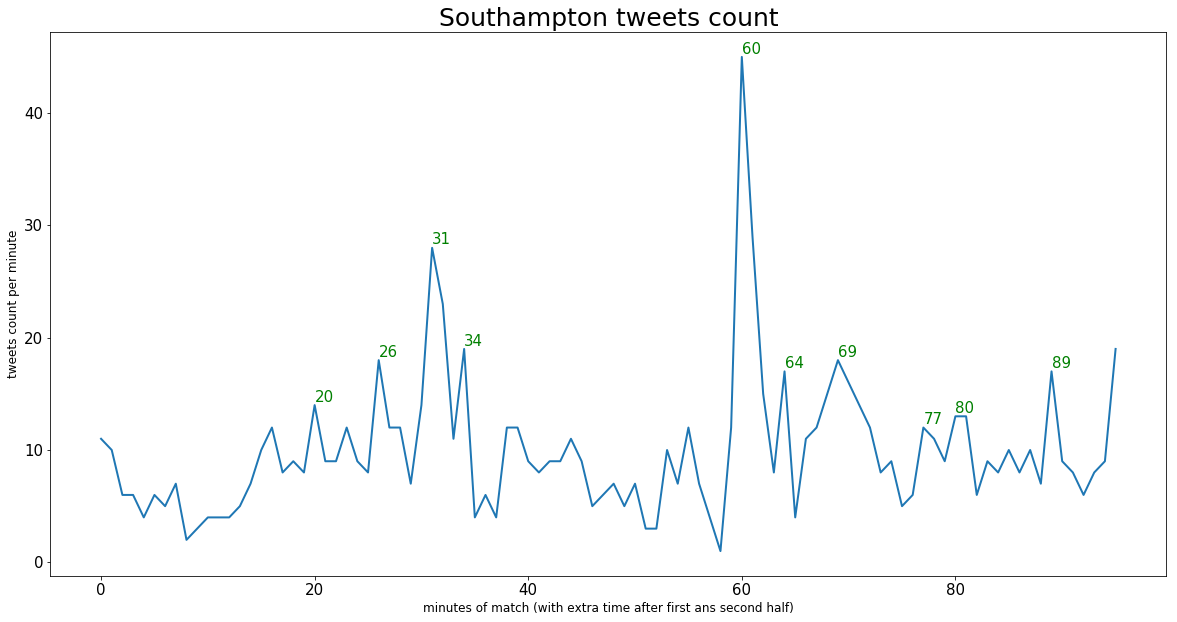

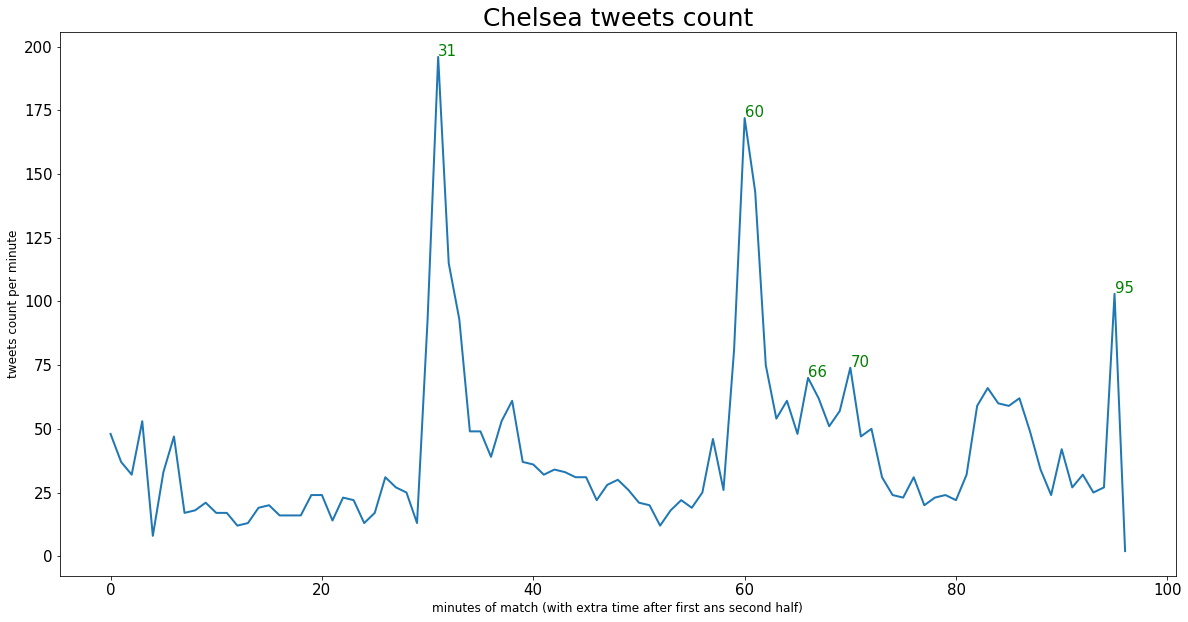

In [272]:
plot_sentiment(team1_count, count_peaks_team1, distance=0.3, title=team1 + " tweets count",
               filename=team1 + '-count.jpg', y_label='tweets count per minute')
plot_sentiment(team2_count, count_peaks_team2, distance=0.3, title=team2 + " tweets count",
               filename=team2 + '-count.jpg', y_label='tweets count per minute')


## CONCLUSIONS

The analyses carried out in this project proved that it is possible to indentify match score by prediction of tweets sentiment. However, different classifiers give different results of the classification. Analyses of several matches showed that fasttext is the best classifier and can be used in almost every case to predict the sentiment. This is the only one classifier which generetes plots with positive and negative sentiment. Unfortunately, plots from other classifiers include only positive values of sentiment.

### PSG - LIV
Match score: 2:3

In this match, PSG sentiment did not provide information about goals of this team. They were hard to identify by each classifier. On the other hand, the results of sentiment prediction for Liverpool were similar for all classifiers and they showed 3 high peaks corresponding to the goals. 

### MAN-NEW
Match score: 3:2

In this case, the goals of Manchester can be indentified best from sentiment predicted by Logistic Regression. Other classifiers which worked also well were: Multinomial Naive Bayes and SVM with feature selection. In contrast, it is possible to identify goals of Newcastle with each classifier besides fasttext. This is the only example in which fasttext did not provide a plot whith peaks related to teams' goals. 

### LIV-MAN
Match score: 0:0

In this match, all classifiers generated plots not showing any special peaks which can point to zero goals for both teams. The plots did not show any important action. We can make conclusion that this match was boring. However, plot with tweets count showed peak for the minute in which there was missed penalty.  

### VAL-BAR
Match score: 1:1

In this case, there was a problem with tweets from Valencia fans - not enough Valencia tweets. Therefore, the plots for Valencia were too short but for Logistic Regression, Bernoulli NB, XGB and fasttext there was a peak corresponding the goal of Valencia team (2').  Barcelona's goals were correct showed on plots provided by all classifiers.

### LEI-EVE
Match score: 1:2

Best results for Leicester and Everton were acheived in fasttext classification. It showed positive peaks for goals and negative for cards receiving and opposite team's goal. Moreover, other classifiers also provided good results for Everton performance, which can not be said about Leicester's goals recognition. For this team, the correct plot is generated only by Bernoulli NB, but it shows high peak in the minute of card receiving - high positive sentiment instead of negative sentiment.

### FUL-ARS
Match score: 1:5

All classifiers worked bad with Fulham's goals identification. The plots did not have any higher peaks. The goal for this team can not be recognized. Arsenal's goals can be correct identified from fasttext plot. Only this classifier shows 5 high peaks. The other classifiers identify only 3 goals. 

### SOU-CHE
Match score: 0:3

In this match, only fasttext plot shows good match course for Southampton team. It is balanced which means that there were no goals of this team. In contrast, all classifiers work well in case of Chelsea performance identification. All of them show 3 main peaks for the exact time of Chelsea's goals.


```
```


******
To sum up, fasttext is the best model for sentiment analysis. It do not need much work with tweets preprocessing and also provides best results for almost every match. 





# What can be the next steps?

In the future, this project may be used in automated goals (and other match events) recognition. There can be next classificication added after sentiment prediciton which identifies the goal time or the time of important action, etc.

It is also worth checking the performance of fasttext models with different vector sizes and also with pretrained vectors - for example popular vectors from Wikipedia.